# Income level classification

The adult income data is extracted from US Cenus Data.
Objective is to predict whether a person makes income greater than 50k or not based on the demographic data we have, using some Machine learning algorithms and compare their results.

In [144]:
# default libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn 
%matplotlib inline
from scipy.stats import ttest_ind, ttest_rel
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for data preprocessing
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# for classifier models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import KFold, cross_val_score

# for models evaluation
from sklearn.metrics import confusion_matrix, accuracy_score

### Fetching the data

In [145]:
income_data = pd.read_csv("adult.csv")
income_data.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


- the column 'fnlwgt' is the 'finalweight'- described as weight of an observation. The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau.
- 'educational-num' - is the Individual's year of receving education
- 'relationship' - is the individual's relation in a family.
The remaining columns are self-explanatory.

### Cleaning the data

We observe that there are some null values and NaN, so lets clean them 

In [146]:
#missing values
income_data.isnull().sum()


age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income             0
dtype: int64

In [147]:
## Lets drop na values
mydata= income_data.dropna()

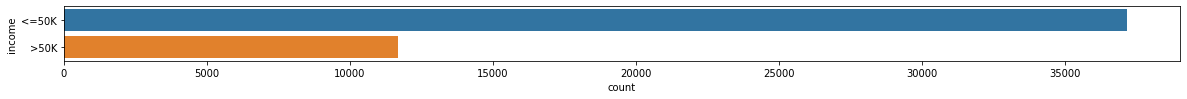

In [148]:
fig = plt.figure(figsize=(20,1))
sns.countplot(y="income", data=mydata)

This plot indicates that **income <=50k is more than 3 times of that of income level>50k**

Let us reduce the number of classes for certains features like marital status can be reduced to 'Married','Not Married','Widowed' and 'Separated'

In [149]:
mydata['marital-status'].replace('Never-married', 'NotMarried',inplace=True)
mydata['marital-status'].replace(['Married-AF-spouse'], 'Married',inplace=True)
mydata['marital-status'].replace(['Married-civ-spouse'], 'Married',inplace=True)
mydata['marital-status'].replace(['Married-spouse-absent'], 'NotMarried',inplace=True)
mydata['marital-status'].replace(['Separated'], 'Separated',inplace=True)
mydata['marital-status'].replace(['Divorced'], 'Separated',inplace=True)
mydata['marital-status'].replace(['Widowed'], 'Widowed',inplace=True)

#### There are many categorical features in the dataset, so lets encode them into numerical values.

In [150]:
mydata = mydata.apply(LabelEncoder().fit_transform)
mydata.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,8,4,19329,1,6,1,7,3,2,1,0,0,39,39,0
1,21,4,4212,11,8,0,5,0,4,1,0,0,49,39,0
2,11,2,25340,7,11,0,11,0,4,1,0,0,39,39,1
3,27,4,11201,15,9,0,7,0,2,1,98,0,39,39,1
4,1,0,5411,15,9,1,0,3,4,0,0,0,29,39,0


- So income level is encoded as **1(>50k>) and 0 (if <=50k)**
- Gender- **Male(1) and Female(0)**


In [151]:
#Scaling function 
def scaled_df(df):
    scaled = pd.DataFrame()
    for item in df:
        if item in df.select_dtypes(include=[np.float]):
            scaled[item] = ((df[item] - df[item].min()) / 
            (df[item].max() - df[item].min()))
        else: 
            scaled[item] = df[item]
    return scaled    
incomedata_scaled = scaled_df(mydata)

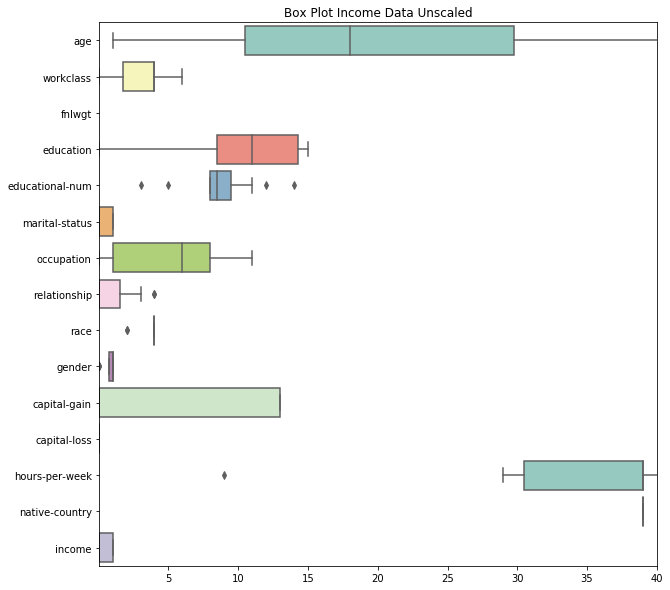

In [152]:
f, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#FFFFFF')
plt.title("Box Plot Income Data Unscaled")
ax.set(xlim=(0.01,40))
ax = sns.boxplot(data = mydata[1:13], 
  orient = 'h', 
  palette = 'Set3')

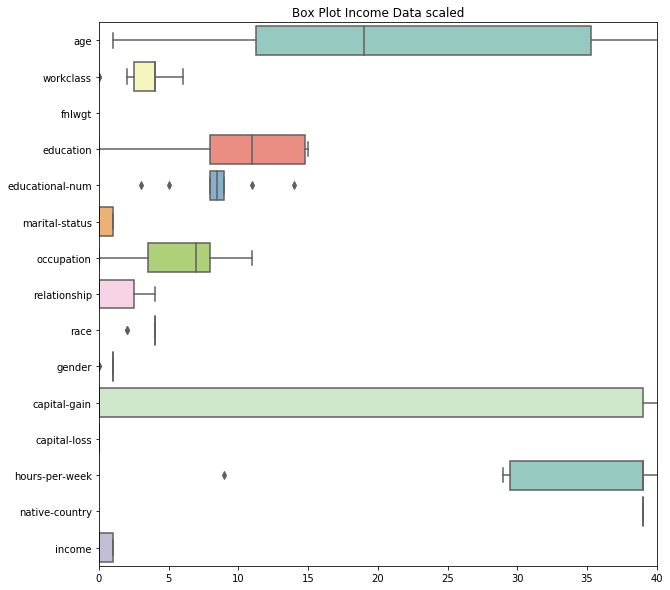

In [153]:
f, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#FFFFFF')
plt.title("Box Plot Income Data scaled")
ax.set(xlim=(-0.0000000000000001,40))
ax = sns.boxplot(data = incomedata_scaled[1:11], 
  orient = 'h', 
  palette = 'Set3')

## Questions

### Is the relationship significant

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


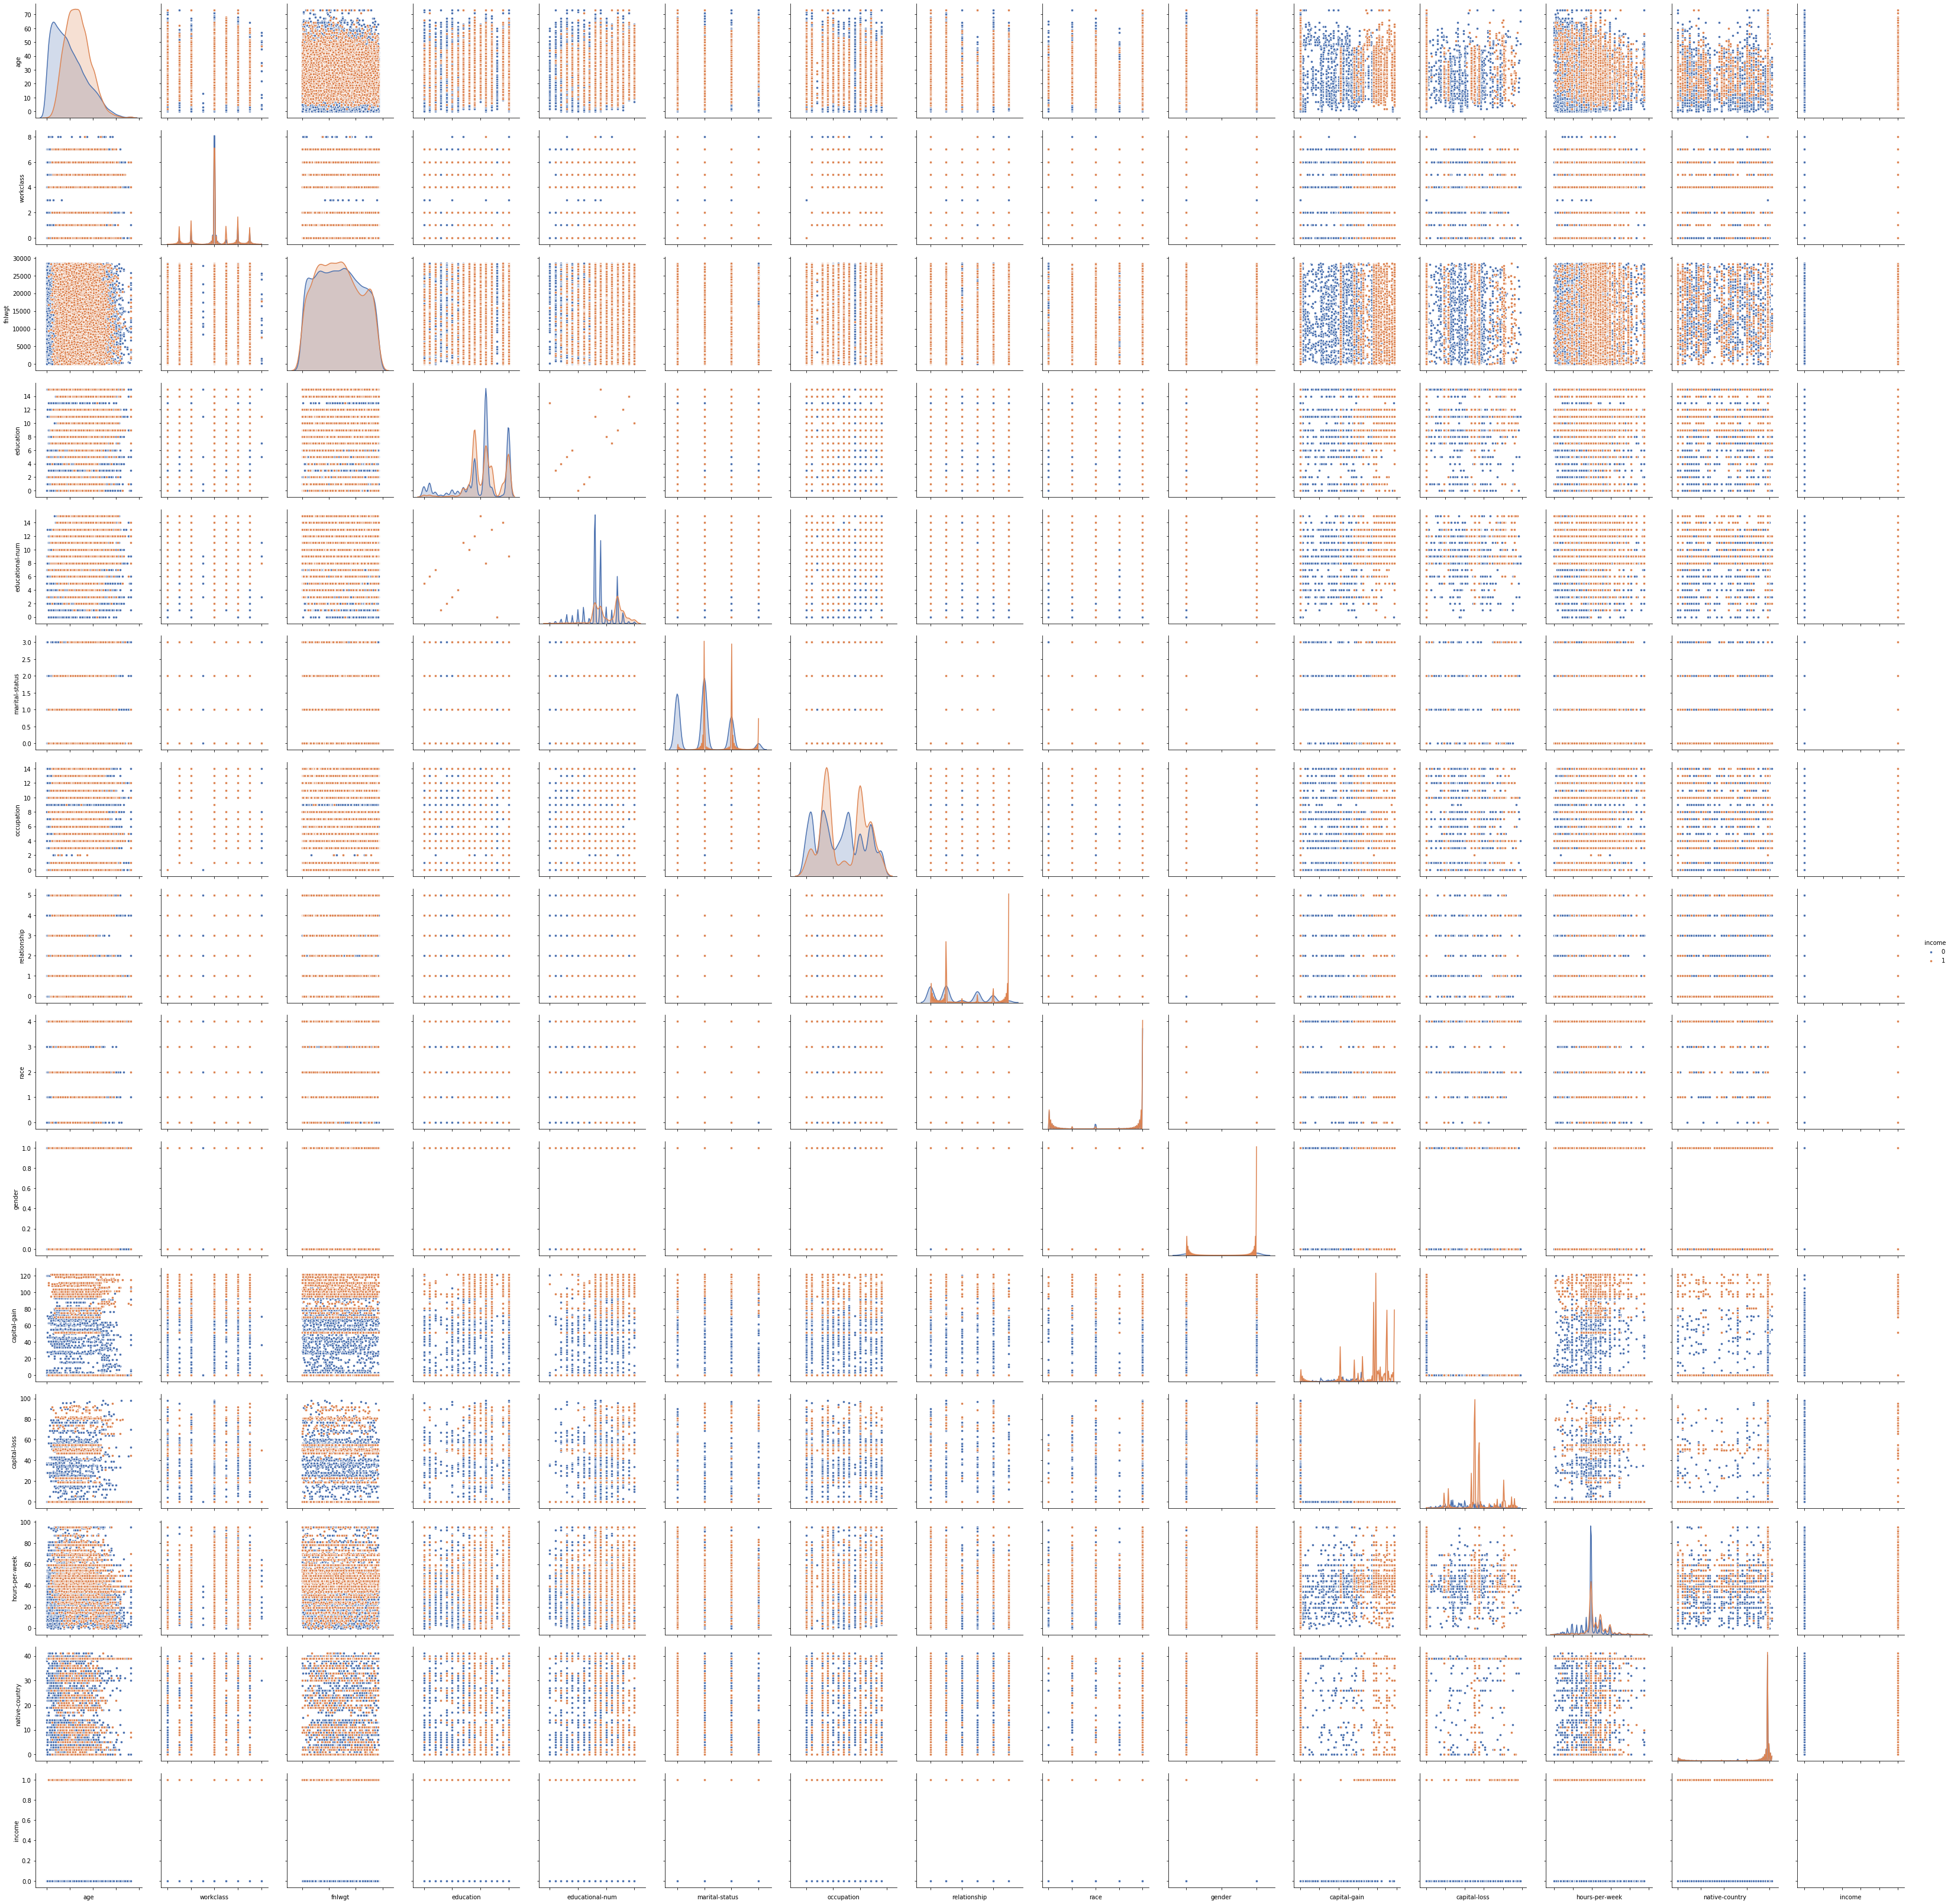

In [154]:
#pair plots 
p = sns.pairplot(mydata, hue = 'income', palette = 'deep', 
                  size=3, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=20) )
p.set(xticklabels=[])

We can see the relationship between the predictors and the target variable pairwise. Now lets do some bivariate anlaysis.

#### Bivariate Analysis 

Age and Income 

In [155]:
mydata[['income', 'age']].groupby(['income'], as_index=False).mean().sort_values(by='age', ascending=False)

,income,age
1,1,27.275178
0,0,19.872184


This indicates that the mean "age" for Income group(<=50k) is 19.8 years.
and for Income group(>50k) is 27.2 years

##### Hypothesis test

Formulate **Null Hypothesis**  - There is no significant difference in the mean age for the 2 income groups

**Alternate Hypothesis** - There is a difference in the mean age for the 2 groups

In [156]:
import random

mydata = mydata[(np.abs(stats.zscore(mydata["age"])) < 3)] 

income_1 = mydata[mydata['income']==1]['age']
income_0 = mydata[mydata['income']==0]['age']

income_0 = income_0.values.tolist()
income_0 = random.sample(income_0, 100)
income_1 = income_1.values.tolist()
income_1 = random.sample(income_1, 100)

In [157]:
from scipy.stats import ttest_ind
ttest,pval = ttest_ind(income_1,income_0,equal_var = False)
print("ttest",ttest)
print('p value',pval)

ttest 3.498243338607593
p value 0.0005959155278940218


As the pvalue is very less , we reject the null hypothesis and conclude that there is a significant difference in the mean age between the 2 income groups

Hence , **Age has some contribution to distinguish the 2 income groups**

**Let us see if it is significant using the stats from a logistic model**

In [158]:
drop_elements = ['income']
y = mydata["income"]
X = mydata.drop(drop_elements, axis=1)

In [159]:
# Using logistic regression model
import statsmodels.discrete.discrete_model as sm
logit_model = sm.Logit(y, X)
result=logit_model.fit()
result.summary()

#params = result.params
#result.conf_int()

Optimization terminated successfully.
         Current function value: 0.382556
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                48656
Model:                          Logit   Df Residuals:                    48642
Method:                           MLE   Df Model:                           13
Date:                Mon, 27 Jan 2020   Pseudo R-squ.:                  0.3052
Time:                        19:51:06   Log-Likelihood:                -18614.
converged:                       True   LL-Null:                       -26791.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                 0.0227      0.001     21.883      0.000       0.021       0.025
workclass          -0.1309      0.009    -14.641      0.000      -0.148      -0.113
fnlwgt          -1.217e-05   1.61e-06     -7.580      0.000   -1.53e-05   -9.02e-06
education          -0.0383      0.004    -10.118      0.000      -0.046      -0.031
educational-num     0.2301      0.005     43.741      0.000       0.220       0.240
marital-status     -1.5064      0.025    -60.578      0.000      -1.555      -1.458
occupation          0.0010      0.003      0.302      0.762      -0.005       0.007
relationship       -0.2220      0.011    -19.362      0.000      -0.245      -0.200
race               -0.2326      0.014    -16.214      0.000      -0.261      -0.204
gender             -0.6524      0.044    -14.846      0.000      -0.739      -0.566
capital-gain        0.0283      0.001     47.794      0.000       0.027       0.029
capital-loss        0.0276      0.001     26.020      0.000       0.026       0.030
hours-per-week      0.0128      0.001     11.845      0.000       0.011       0.015
native-country     -0.0327      0.001    -22.669      0.000      -0.035      -0.030
===================================================================================
"""

***p values for all the variables are smaller than 0.05 except for occupation, hence we can remove that.****

In [160]:
drop_elements = ['income','occupation']
y = mydata["income"]
X = mydata.drop(drop_elements, axis=1)

### Is there any multi-collinearity in the model?

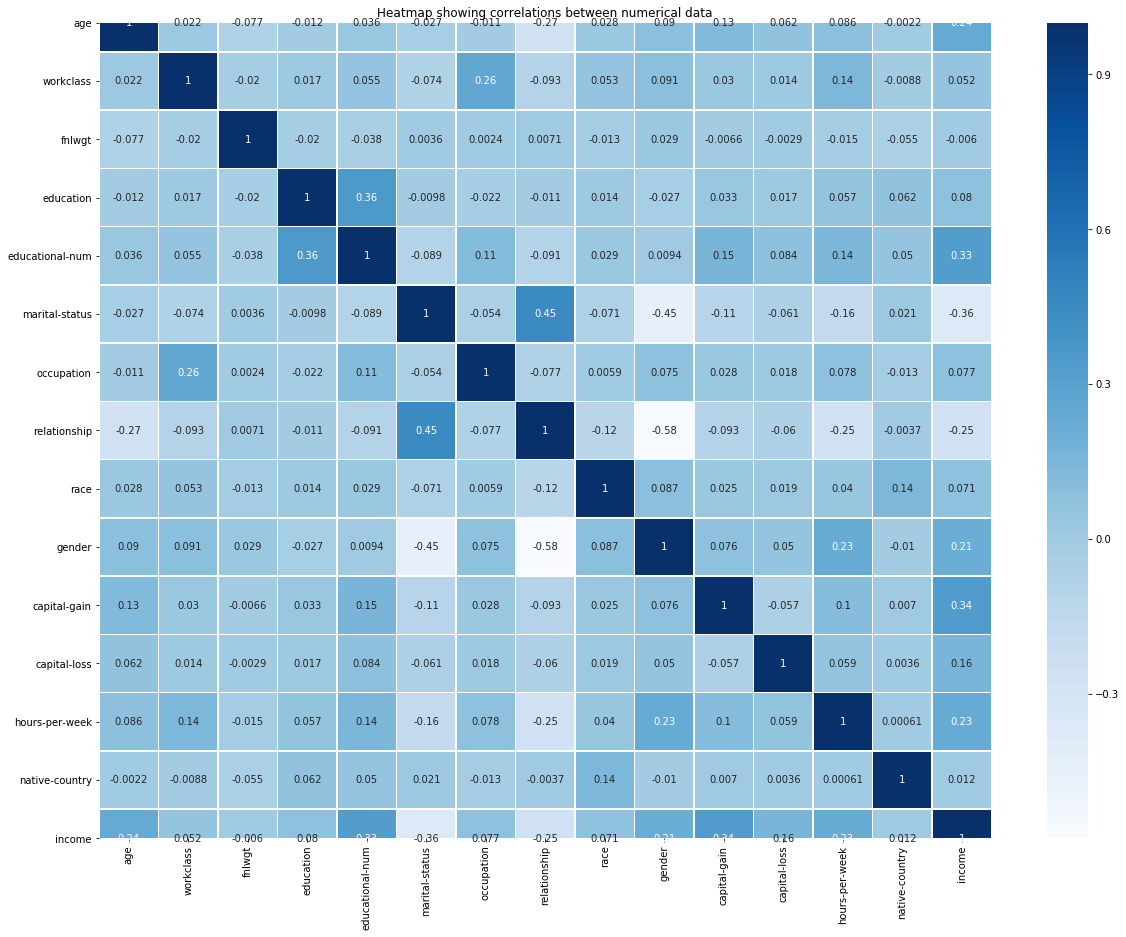

In [161]:
mydata.corr()
data1=mydata.drop('income',axis=1)
plt.figure(figsize=(20,15))  
sns.heatmap(mydata.corr(),annot=True,linewidths=.5, cmap="Blues")
plt.title('Heatmap showing correlations between numerical data')
plt.show()

- There is no strong correlation among the attributes, neither strong positive nor strong negative.
- The highest is **0.45 between relationship and marital status** and then **0.36 between education and educational-num(both indicate the same , so can ignore one of them)** and **0.34 between income and capital gain**.
- Highest negative correlation exists between **gender and relationship(-0.58)**, so we can remove one of them during model predictions.And simlarly between **gender and marital status(-0.45)**.

***Multi-collinearity*** refers to the correlation between the independent variables. As we have seen, there is no strong correlation among the independent variables as evident from the correlation heat map.
- But let us find the **Variance Inflation factor** to quantify that correlation between the independent variables.

In [162]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
#X1=X.drop('hours-per-week',axis=1)
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

In [163]:
vif.round(1)

,VIF Factor,features
0,3.7,age
1,7.8,workclass
2,3.8,fnlwgt
3,9.1,education
4,15.1,educational-num
5,2.5,marital-status
6,2.8,relationship
7,17.2,race
8,4.6,gender
9,1.1,capital-gain


VIF is high for **workclass , educational-num,education, race, hours-per week and native-country**. So there exists multicollinearity.  education and educational-num might be highly correlated, so we can remove one of them as they might have redundant effects.

Based on pvalue and vif value and ranks of the predictors , lets remove some of the variables - occupation(high p value), race and native country.

### ML models

#### Train test split

In [164]:
drop_elements = ['income','occupation','race','native-country','education']
y = mydata["income"]
X = mydata.drop(drop_elements, axis=1)
X.head()


,age,workclass,fnlwgt,educational-num,marital-status,relationship,gender,capital-gain,capital-loss,hours-per-week
0,8,4,19329,6,1,3,1,0,0,39
1,21,4,4212,8,0,0,1,0,0,49
2,11,2,25340,11,0,0,1,0,0,39
3,27,4,11201,9,0,0,1,98,0,39
4,1,0,5411,9,1,3,0,0,0,29


In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

## Logistic Regression

In [166]:
# Logistic Regression
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)
y_pred = logreg_model.predict(X_test)
score_logreg = logreg_model.score(X_test,y_test)
print("Accuracy of logistic regression model is ",metrics.accuracy_score(y_test, y_pred))


/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression model is  0.8037402383888204


## RandomForest Classification

In [167]:
# Random Forest Classifier
randomforest = RandomForestClassifier(bootstrap=True)
randomforest.fit(X_train, y_train)
y_pred = randomforest.predict(X_test)
#score_randomforest = randomforest.score(X_test,y_test)
#print('The accuracy of the Random Forest Model is', score_randomforest)
print("Accuracy of Randome Forest model is ",metrics.accuracy_score(y_test, y_pred))

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy of Randome Forest model is  0.8439169749280724


## K-Nearest Neighbours

In [168]:

knn_k = []
for i in range(0,33):  # try up to k=33
    if (i % 2 != 0): # Use only odd k 
        knn_k.append(i)

cross_vals = []
for k in knn_k:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn,
                             X_train, 
                             y_train, 
                             cv = 10, 
                             scoring='accuracy')
    cross_vals.append(scores.mean())

MSE = [1 - x for x in cross_vals]
optimal_k = knn_k[MSE.index(min(MSE))]
print("Optimal K is {0}".format(optimal_k))

Optimal K is 17


In [169]:
# K-Nearest Neighbours
knn = KNeighborsClassifier(n_neighbors=15)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
#score_knn = knn.score(X_test,y_test)

print("The Accuracy score of kNN model is %s" %metrics.accuracy_score(y_test, y_pred))

The Accuracy score of kNN model is 0.7898684751335799


## Gaussian Naive Bayes

In [170]:
gaussian = GaussianNB()
GB_model=gaussian.fit(X_train, y_train)
# y_pred = gaussian.predict(X_test)
score_gaussian = gaussian.score(X_test,y_test)
print('The accuracy of Gaussian Naive Bayes is', score_gaussian)

The accuracy of Gaussian Naive Bayes is 0.8031237155774764


 ***RandomForest is the most accurate model***

### In the multivariate models are predictor variables independent of all the other predictor variables?
- **No** they are not independent.
- There is no strong correlation as evident from the correlation heat map above but there is collinearity among variables as indicated by VIF above.

### In multivariate models rank the most significant predictor variables and exclude insignificant ones from the model

In [171]:
field_names=mydata.columns[0:13]
predictors=field_names.tolist()
predictors

['age',
 'workclass',
 'fnlwgt',
 'education',
 'educational-num',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'gender',
 'capital-gain',
 'capital-loss',
 'hours-per-week']

In [172]:
def rank_predictors(dat,l,f='income'):
    rank={}
    max_vals=dat.max()
    median_vals=dat.groupby(f).median()  # We are using the median as the mean is sensitive to outliers
    for p in l:
        score=np.abs((median_vals[p][1]-median_vals[p][0])/max_vals[p])
        rank[p]=score
    return rank


In [173]:
pred_rank=rank_predictors(mydata,predictors) 
pred_rank

{'age': 0.14516129032258066,
 'workclass': 0.0,
 'fnlwgt': 0.011079166958838791,
 'education': 0.0,
 'educational-num': 0.2,
 'marital-status': 0.3333333333333333,
 'occupation': 0.0,
 'relationship': 0.2,
 'race': 0.0,
 'gender': 0.0,
 'capital-gain': 0.0,
 'capital-loss': 0.0,
 'hours-per-week': 0.0}

In [174]:
pred_rank_1=sorted(pred_rank.items(), key=lambda x: x[1])
pred_rank_1

[('workclass', 0.0),
 ('education', 0.0),
 ('occupation', 0.0),
 ('race', 0.0),
 ('gender', 0.0),
 ('capital-gain', 0.0),
 ('capital-loss', 0.0),
 ('hours-per-week', 0.0),
 ('fnlwgt', 0.011079166958838791),
 ('age', 0.14516129032258066),
 ('educational-num', 0.2),
 ('relationship', 0.2),
 ('marital-status', 0.3333333333333333)]

So the most useful predictors are **age, educational-num, relationship, marital status**, with **marital-status** being the **top ranked** predictor

### Which independent variables are significant?
- **marital-status, educational-num and relationship**

In [175]:
pred_rank_1

[('workclass', 0.0),
 ('education', 0.0),
 ('occupation', 0.0),
 ('race', 0.0),
 ('gender', 0.0),
 ('capital-gain', 0.0),
 ('capital-loss', 0.0),
 ('hours-per-week', 0.0),
 ('fnlwgt', 0.011079166958838791),
 ('age', 0.14516129032258066),
 ('educational-num', 0.2),
 ('relationship', 0.2),
 ('marital-status', 0.3333333333333333)]

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


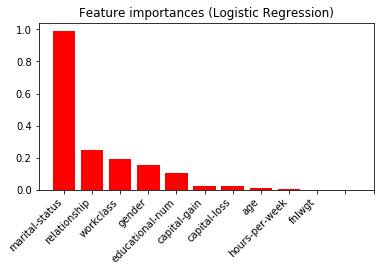

In [182]:
clf_logistic = LogisticRegression(max_iter=3000)
clf_logistic.fit(X_train, y_train)
coefs = np.abs(clf_logistic.coef_[0])
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Logistic Regression)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(12), X_train.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

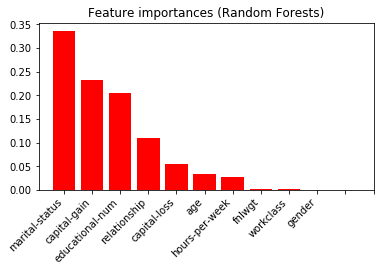

In [183]:
clf = RandomForestClassifier(n_jobs=-1, random_state=42, n_estimators=400, max_depth=6, max_features=6) #has already been tuned
clf.fit(X_train, y_train)
coefs = clf.feature_importances_
indices = np.argsort(coefs)[::-1]

plt.figure()
plt.title("Feature importances (Random Forests)")
plt.bar(range(10), coefs[indices[:10]],
       color="r", align="center")
plt.xticks(range(12), X_test.columns[indices[:12]], rotation=45, ha='right')
plt.subplots_adjust(bottom=0.3)

plt.ion(); plt.show()

In [184]:
feauter_imp = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': clf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
feauter_imp.head()

,feature,importance
4,marital-status,0.336488
7,capital-gain,0.232103
3,educational-num,0.204993
5,relationship,0.108791
8,capital-loss,0.054729


***marital-status, capital-gain, educational-num, relationship, capital-loss are important predictors.***

### Cross validation

Performing kfold cross validation for evaluating the models performances.

In [ ]:
### cross validation
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10, random_state=22) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Logistic Regression','KNN','Random Forest', 'Gaussian Naive Bayes']
models=[LogisticRegression(),KNeighborsClassifier(n_neighbors=9),RandomForestClassifier(n_estimators=100),GaussianNB()]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
models_dataframe=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)       
models_dataframe

Random Forest is most accurate

### Are any model assumptions violated?

- Binary **logistic regression** requires the dependent variable to be binary - **Not violated**
- For a binary regression, the factor level 1 of the dependent variable should represent the desired outcome.
- Only the meaningful variables should be included - **Not violated**
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity - **Violated** as there is multicollinearity.
- The independent variables are linearly related to the log odds - **Not violated**
- Logistic regression requires quite large sample sizes - **Not violated**

- **RandomForest** -  it is a nonparametric method (i.e., it does not have distributional assumptions) 
- While building we do not use the whole dataset, but bootstrap sample- **Not violated** as in the classifier parameters , we have set the sampling method

- **KNN** assumes that similar data points are close to each other and predicts based on that assumption.

- **Gaussian Naive Bayes** - The basic naive bayes assumption is that each feature makes independent and equal contribution to outcome.- Not the case as we have different correlations between the independent variables and the outcome.
- Asume that the conitnuous independent variables are normally distributed - **Violated** because we some independent variables are discrete or categorical.

### Does the model make sense?

In [185]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)


[[7139  212]
 [1833  548]]


So according to this , we have a total of(7139+548) **7687 correct predictions** and (1833+212) **2045 wrongly predicted data points**

The models predict 7687 times the true income level correctly.

### Does regularization help?

Let us investigate

**Using statsmodel**

In [186]:
# L1 regularization to penalize the coefficients. 
result_regularized=logit_model.fit_regularized(method='l1')
result_regularized.summary()

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/discrete/discrete_model.py:1789: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.382555650635513
            Iterations: 34
            Function evaluations: 54
            Gradient evaluations: 34


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 income   No. Observations:                48656
Model:                          Logit   Df Residuals:                    48642
Method:                           MLE   Df Model:                           13
Date:                Mon, 27 Jan 2020   Pseudo R-squ.:                  0.3052
Time:                        19:58:36   Log-Likelihood:                -18614.
converged:                       True   LL-Null:                       -26791.
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                 0.0227      0.001     21.882      0.000       0.021       0.025
workclass          -0.1309      0.009    -14.641      0.000      -0.148      -0.113
fnlwgt          -1.217e-05   1.61e-06     -7.580      0.000   -1.53e-05   -9.02e-06
education          -0.0383      0.004    -10.118      0.000      -0.046      -0.031
educational-num     0.2301      0.005     43.741      0.000       0.220       0.240
marital-status     -1.5064      0.025    -60.578      0.000      -1.555      -1.458
occupation          0.0010      0.003      0.303      0.762      -0.005       0.007
relationship       -0.2220      0.011    -19.361      0.000      -0.245      -0.200
race               -0.2326      0.014    -16.215      0.000      -0.261      -0.204
gender             -0.6523      0.044    -14.845      0.000      -0.738      -0.566
capital-gain        0.0283      0.001     47.794      0.000       0.027       0.029
capital-loss        0.0276      0.001     26.020      0.000       0.026       0.030
hours-per-week      0.0128      0.001     11.845      0.000       0.011       0.015
native-country     -0.0327      0.001    -22.669      0.000      -0.035      -0.030
===================================================================================
"""

In [189]:
result_regularized.pred_table()

array([[34471.,  2527.],
       [ 6081.,  5577.]])

In [190]:
result.pred_table()

array([[34471.,  2527.],
       [ 6081.,  5577.]])

**Using scikitlearn**

C is our regularization parameter 
- Let us check if updating C value helps.

In [191]:
logreg = LogisticRegression(C=.001)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Logistic Regression is 0.8068228524455405


In [192]:
logreg = LogisticRegression(C=.1)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Logistic Regression is 0.8034319769831484


In [193]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7351
           1       0.69      0.35      0.47      2381

    accuracy                           0.80      9732
   macro avg       0.76      0.65      0.67      9732
weighted avg       0.79      0.80      0.78      9732



In [194]:
logreg = LogisticRegression(C=10)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Logistic Regression is 0.803534730785039


No imporvement of accuracy. Let us try with C=1000

In [195]:
logreg = LogisticRegression(C=1000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
score_logreg = logreg.score(X_test,y_test)
print('The accuracy of the Logistic Regression is', score_logreg)

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The accuracy of the Logistic Regression is 0.803534730785039


No significant impact due to regularization.

In [196]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.95      0.88      7351
           1       0.69      0.35      0.47      2381

    accuracy                           0.80      9732
   macro avg       0.76      0.65      0.67      9732
weighted avg       0.79      0.80      0.78      9732



In [197]:
#Scaling
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.fit_transform(X_test)


In [198]:
#from sklearn import modelse
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
clf = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
GridSearchCV(cv=None,
             estimator=LogisticRegression(C=1.0, intercept_scaling=1,   
               dual=False, fit_intercept=True, penalty='l2', tol=0.0001),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

GridSearchCV(cv=None, error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Which hyperparameters are important?

**KNN** is a non-parametric method. It has a tuning parameter - k, the nearest neighbours to be considered for classification. 

**Logistic Regression** - 
1) Penalty- to specify the type of normalization used.
2) C- inverse of regularization, smaller vaues indicate a stronger regularization.
3) random-state- seed used by random generator
4) Solver: This indicates which algorithm to use in the optimization problem. Default value is lbfgs. other possible values are newton-cg, liblinear, sag, saga.
5) Max iter : max_iter represents maximum number of iterations taken for the solvers to converge a training process.

Important hyperparameters are **penalty and inverse regularization param(C)**, lets tune them to find the best parameters.

In [199]:
log_model = LogisticRegression(solver='liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Creating grid search using 5-fold cross validation
clf = GridSearchCV(log_model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, y)


#Best hyper parameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])



Best Penalty: l1
Best C: 166.81005372000593


**RandomForest**  - Set of hyperparameters are 
1) n_estimators = number of trees in the foreset
2) max_features = max number of features considered for splitting a node
3) max_depth = max number of levels in each decision tree
4) min_samples_split = min number of data points placed in a node before the node is split
5) min_samples_leaf = min number of data points allowed in a leaf node
6) bootstrap = method for sampling data points (with or without replacement)

Tuning the hyperparameters for Random Forest

In [202]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 1, verbose = 2)

/Users/harika/Applications/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [203]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   1.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.9s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   1.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   3.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   3.9s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   3.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000, total=  16.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   1.7s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   1.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sa

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=  16.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000, total=  16.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   2.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   2.2s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, mi

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=  23.0s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000, total=  21.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 


KeyboardInterrupt: 

In [ ]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, test_features, test_labels)

### Conclusion

- Random Forest yields the highest accuracy of all classification models tried.
- Important predictors used to predict the income class are education-num, relationship, marital status, capital gain, capital loss and age.
- There exists multicollinearity for certain independent variables like workclass , educational-num, race and hours-per week as per the VIF values, so we can ignored some of them to imporve the models accuracy. From the correlation heatmap,  we saw that there was no strong correlation , but the maximum was 0.45 between marital status and relationship and a -0.58 between gender and relationship.
- Regularization did not help much as there is no significant improvement in the predictions as seen for logistic regression. 


## License 

Copyright 2019 Harika Reddy Gurram

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.